# **StockMate: Smart Inventory & Sales Manager**

**Before running the program upload the products.csv file to**  
https://drive.google.com/file/d/1dVlHb6bXQqs9PeZ6qQflmXDnLAvX-e2d/view?usp=drive_link

In [ ]:
import csv
from datetime import datetime
import pandas as pd
import numpy as np
import os
import functools


In [ ]:
# Decorator to log function calls
def log_function_call(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        with open("function_log.txt", "a") as log_file:
            log_file.write(f"{datetime.now()} - Called {func.__name__}\n")
        return result
    return wrapper


In [ ]:
# Product Class
class Product:
    def __init__(self, product_id, name, price, quantity, date):
        self.product_id = str(product_id)
        self.name = name
        self.price = float(price)
        self.quantity = int(quantity)
        self.date = date

    def __repr__(self):
        return f"Product({self.product_id}, {self.name}, {self.price}, {self.quantity}, {self.date})"


In [ ]:
# Inventory Class
class Inventory:
    def __init__(self):
        self.products = {}

    @log_function_call # Add a new product to the inventory.
    def add_product(self, product):
        if product.product_id in self.products:
            print(f'Product with ID {product.product_id} already exists.')
        else:
            self.products[product.product_id] = product
            print(f'Product {product.name} added to inventory.')

    @log_function_call # Update an existing product's details
    def update_product(self, product_id, name=None, price=None, quantity=None, date=datetime.now):
        product_id = str(product_id) # Ensure product ID is treated as a string
        if product_id in self.products:
            if name:
                self.products[product_id].name = name
            if price:
                self.products[product_id].price = float(price)
            if quantity:
                self.products[product_id].quantity = int(quantity)
            if date is None:
                date = datetime.now()
            self.products[product_id].date = date
            print(f'Product with ID {product_id} updated.')
        else:
            print(f'Product with ID {product_id} does not exist.')

    @log_function_call # Delete a product from the inventory.
    def delete_product(self, product_id):
        if product_id in self.products:
            del self.products[product_id]
            print(f'Product with ID {product_id} deleted.')
        else:
            print(f'Product with ID {product_id} does not exist.')

    @log_function_call # Search for a product by its ID.
    def search_product(self, product_id):
        return self.products.get(product_id, 'Product not found.')

    @log_function_call # Save inventory to a CSV file.
    def save_to_csv(self, filename='products.csv'):
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Product_ID', 'Name', 'Price', 'Quantity', 'Date'])
            for product in self.products.values():
                writer.writerow([product.product_id, product.name, product.price, int(product.quantity), product.date])
        print(f'Inventory saved to {filename}.')

    @log_function_call # Load inventory from a CSV file.
    def load_from_csv(self, filename='products.csv'):
        try:
            with open(filename, 'r') as file:
                reader = csv.DictReader(file)
                for row in reader:
                    product_id = row['Product_ID']
                    name = row['Name']
                    price = float(row['Price'])
                    quantity = int(row['Quantity'])
                    date = row['Date']
                    product = Product(product_id, name, price, quantity, date)
                    self.products[product_id] = product
            print(f'Inventory loaded from {filename}.')
        except FileNotFoundError:
            print(f'Error: {filename} not found.')

    def total_stock_value(self):
        total_value = sum(product.price * product.quantity for product in self.product.values())
        print(f'Total Stock Value: ${total_value}')
        return total_value


In [ ]:
# Sales Class
class Sales:
    def __init__(self):
        self.sales_data = [] # List to store sales transactions

    @log_function_call # Process a sale by updating the product quantity in inventory.
    def process_sale(self, product_id, quantity, inventory):
        product = inventory.search_product(product_id)
        if isinstance(product, Product) and product.quantity >= quantity:
            total_cost = product.price * quantity
            product.quantity -= quantity
            dates = product.date
            sale_record = {
                'Product_ID': product_id,
                'Name': product.name,
                'Quantity': quantity,
                'Price': product.price,
                'Total Cost': total_cost,
                'Date': dates
            }
            self.sales_data.append(sale_record)
            print(f'Sale processed for {quantity} units of {product.name}.')
        else:
            print(f'Sale failed. Insufficient quantity or product not found.')

    @log_function_call # Save sales records to a CSV file.
    def save_sales_to_csv(self, filename='sales.csv'):
        if not self.sales_data:
            print('No sales data to save.')
            return

        with open(filename, 'a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=['Product_ID', 'Name', 'Quantity', 'Price', 'Total Cost', 'Date'])
            if file.tell() == 0:
                writer.writeheader()
            writer.writerows(self.sales_data)
        print(f'Sales data saved to {filename}.')

    @log_function_call # Load the sales data to sales.csv
    def load_sales_from_csv(self, filename='sales.csv'):
        if not os.path.isfile(filename):
            print(f"{filename} not found. No sales data loaded.")
            return

        try:
            with open(filename, 'r') as file:
                reader = csv.DictReader(file)
                if not reader.fieldnames:
                    print("Sales file is empty or has no headers.")
                    return
                self.sales_data = [row for row in reader]
            print(f'Sales data loaded from {filename}.')
        except Exception as e:
            print(f"Error loading sales data: {e}")

    # Process sales data from a CSV file
    def process_sales_data(self, inventory, sales_file='products.csv'):
        skipped_sales_count = 0
        not_enough_stock = 0
        self.sales_data.clear()
        # Read sales data from the file
        try:
            with open(sales_file, 'r') as file:
                reader = csv.DictReader(file)

                if 'Product_ID' not in reader.fieldnames or 'Quantity' not in reader.fieldnames:
                    print("CSV file doesn't have the expected headers.")
                    return

                for row in reader:
                    product_id = row['Product_ID']
                    quantity_sold = int(row['Quantity'])

                    if product_id in inventory.products:
                        product = inventory.products[product_id]
                        total_cost = product.price * quantity_sold

                        if product.quantity >= quantity_sold:
                            product.quantity -= quantity_sold
                            dates = product.date

                            sale_record = {
                                'Product_ID': product_id,
                                'Name': product.name,
                                'Quantity': quantity_sold,
                                'Price': product.price,
                                'Total Cost': total_cost,
                                'Date': dates
                            }

                            if not any(s['Product_ID'] == product_id and s['Quantity'] == quantity_sold for s in self.sales_data):
                                self.sales_data.append(sale_record)
                            else:
                                skipped_sales_count += 1
                        else:
                            not_enough_stock += 1
                    else:
                        print(f'Product ID {product_id} not found in inventory.')

        except FileNotFoundError:
            print(f"{sales_file} not found. No sales data processed.")

    @log_function_call # Display the top 5 sales by total cost
    def display_top_5_sales(self):
        if not self.sales_data:
            print("No sales data available.")
            return

        sorted_sales = sorted(self.sales_data, key=lambda x: x['Total Cost'], reverse=True)
        top_5 = sorted_sales[:5]

        print("Top 5 Sales by Total Cost:")
        for sale in top_5:
            print(f"{sale['Name']}, {sale['Quantity']}, {sale['Total Cost']}")

    @log_function_call # Calculate total revenue using Numpy.
    def calculate_total_revenue(self):
        if not self.sales_data:
            print("No sales data available for calculation.")
            return

        # Convert 'Total Cost' to float explicitly
        total_revenue = np.sum([float(sale['Total Cost']) for sale in self.sales_data])
        print(f'Total Revenue: ${total_revenue}')
        return total_revenue

    @log_function_call # Perform basic statistics using Pandas
    def sales_statistics(self):
        if not self.sales_data:
            print("No sales data available.")
            return

        sales_df = pd.DataFrame(self.sales_data)

        # Convert 'Total Cost' and 'Quantity' to numeric values explicitly
        sales_df['Total Cost'] = pd.to_numeric(sales_df['Total Cost'], errors='coerce')
        sales_df['Quantity'] = pd.to_numeric(sales_df['Quantity'], errors='coerce')

        sales_df['Date'] = pd.to_datetime(sales_df['Date'])
        sales_df['Day'] = sales_df['Date'].dt.date

        # Average sales per day
        avg_sales_per_day = sales_df.groupby('Day')['Total Cost'].sum().mean()
        print(f'Average Sales per Day: ${avg_sales_per_day:.2f}')

    @log_function_call # Moving average prediction
    def predict_stock_needs(self, window=3):
        if not self.sales_data:
            print("No sales data available for prediction.")
            return

        sales_df = pd.DataFrame(self.sales_data)

        # Convert 'Quantity' to numeric values explicitly
        sales_df['Quantity'] = pd.to_numeric(sales_df['Quantity'], errors='coerce')

        sales_df['Date'] = pd.to_datetime(sales_df['Date'])
        sales_df.set_index('Date', inplace=True)

        # Resample by day and sum the quantity sold
        daily_sales = sales_df['Quantity'].resample('D').sum().fillna(0)

        # Calculate simple moving average
        moving_avg = daily_sales.rolling(window=window).mean()
        print(f'Predicted sales using {window}-day moving average:')
        print(moving_avg.tail())

        return moving_avg

    @log_function_call
    def clear_data(self):
        self.sales_data.clear()


In [ ]:
# Store Class
class Store:
    def __init__(self):
        self.inventory = Inventory()
        self.sales = Sales()

    @log_function_call
    def make_sale(self, product_id, quantity_sold):
        product = self.inventory.search_product(product_id)
        if isinstance(product, Product):
            self.sales.process_sale(product_id, quantity_sold, self.inventory)
            self.inventory.save_to_csv()
        else:
            print("Product not found or invalid")

    @log_function_call # Backup Inventory data.
    def backup_inventory(self, filename='backup_products.csv'):
        self.inventory.save_to_csv(filename)
        print(f'Inventory backed up to {filename}.')

    @log_function_call # Predict stock needs
    def predict_future_stock_needs(self):
        self.sales.predict_stock_needs()


In [ ]:
# User input Functions
def input_product_data(): # Get product information from user input.
    product_id = input('Enter Product ID: ')
    name = input('Enter Product Name: ')
    price = float(input('Enter Product Price: '))
    quantity = int(input('Enter Product Quantity: '))
    date = datetime.now()
    return Product(product_id, name, price, quantity, date)

def update_product_data(): # Get updated product information from user.
    product_id = input('Enter Product ID to update: ')
    name = input('Enter New Product Name (or press Enter to skip): ')
    price = input('Enter New Product Price (or press Enter to skip): ')
    quantity = input('Enter New Product Quantity (or press Enter to skip): ')
    price = float(price) if price else None
    quantity = int(quantity) if quantity else None
    return Product(product_id, name, price, quantity)


In [ ]:
# Main Program
def main():
    store = Store()

    # Load inventory from CSV if exists
    store.inventory.load_from_csv()
    store.sales.process_sales_data(store.inventory)
    store.sales.save_sales_to_csv()
    store.sales.load_sales_from_csv()

    while True:
        print('\nOptions:')
        print('1. Add Product')
        print('2. Update Product')
        print('3. Delete Product')
        print('4. Search Product')
        print('5. Top 5 Product Sales')
        print('6. Data Analysis')
        print('7. Save and Exit')

        choice = int(input('Enter your choice: '))

        if choice == 1:
            product = input_product_data()
            store.inventory.add_product(product)

        elif choice == 2:
            product = update_product_data()
            store.inventory.update_product(product.product_id, product.name, product.price, product.quantity, product.date)

        elif choice == 3:
            product_id = input('Enter Product ID to delete: ')
            store.inventory.delete_product(product_id)

        elif choice == 4:
            product_id = input('Enter Product ID to search: ')
            product = store.inventory.search_product(product_id)
            print(product)

        elif choice == 5:
            store.sales.display_top_5_sales()

        elif choice == 6:
            while True:
                print('\nData Analysis Options:')
                print('1. Calculate Total Revenue')
                print('2. View Sales Statistics')
                print('3. Predict Future Stock Needs')
                print('4. Back')

                choice = int(input('Enter your choice: '))

                if choice == 1:
                    store.sales.calculate_total_revenue()

                elif choice == 2:
                    store.sales.sales_statistics()

                elif choice == 3:
                    store.predict_future_stock_needs()

                elif choice == 4:
                    break

                else:
                    print('Invalid choice. Please try again.')

        elif choice == 7:
            store.backup_inventory()
            store.inventory.save_to_csv()
            store.sales.save_sales_to_csv()
            store.sales.clear_data()
            print('Exiting program.')
            break

        else:
            print('Invalid choice. Please try again.')


In [ ]:
if __name__ == "__main__":
    main()

Inventory loaded from products.csv.
Sales data saved to sales.csv.
Sales data loaded from sales.csv.

Options:
1. Add Product
2. Update Product
3. Delete Product
4. Search Product
5. Top 5 Product Sales
6. Data Analysis
7. Save and Exit
Enter your choice: 5
Top 5 Sales by Total Cost:
Smartphone, 9, 99819.0
Smartphone, 9, 99819.0
Laptop, 15, 98850.0
Laptop, 15, 98850.0
Keyboard, 1, 9879.0

Options:
1. Add Product
2. Update Product
3. Delete Product
4. Search Product
5. Top 5 Product Sales
6. Data Analysis
7. Save and Exit
Enter your choice: 6

Data Analysis Options:
1. Calculate Total Revenue
2. View Sales Statistics
3. Predict Future Stock Needs
4. Back
Enter your choice: 4

Options:
1. Add Product
2. Update Product
3. Delete Product
4. Search Product
5. Top 5 Product Sales
6. Data Analysis
7. Save and Exit
Enter your choice: 7
Inventory saved to backup_products.csv.
Inventory backed up to backup_products.csv.
Inventory saved to products.csv.
Sales data saved to sales.csv.
Exiting prog

# **Data Analysis**

In [ ]:
class SalesAnalysis:
    def __init__(self, products_file='products.csv', sales_file='sales.csv'):
        self.products_file = products_file
        self.sales_file = sales_file

        self.products_df = pd.read_csv(products_file, dtype= {'Product_ID': str})
        self.products_df['Product_ID'] = self.products_df['Product_ID'].str.strip().str.lower()

        self.sales_df = pd.read_csv(sales_file, dtype={'Product_ID': str})
        self.sales_df['Product_ID'] = self.sales_df['Product_ID'].str.strip().str.lower()

        # Convert the Date column in the sales data to a datetime object
        self.sales_df['Date'] = pd.to_datetime(self.sales_df['Date'])

    def total_sales_per_product(self):
        total_sales = self.sales_df.groupby('Product_ID').agg({
            'Quantity': 'sum',
            'Total Cost': 'sum'
        }).reset_index()

        total_sales = total_sales.merge(self.products_df[['Product_ID', 'Name']], on='Product_ID', how='left')
        total_sales = total_sales[['Product_ID', 'Name', 'Quantity', 'Total Cost']]
        print("Total Sales for Each Product:")
        print(total_sales)

    # Method to show daily, weekly, or monthly sales trends
    def sales_trends(self, frequency='M'):
      if frequency == 'D':
          sales_trend = self.sales_df.resample('D', on='Date').agg({
              'Quantity': 'sum',
              'Total Cost': 'sum'
          }).reset_index()
          print("Daily Sales Trends:")
      elif frequency == 'W':
          sales_trend = self.sales_df.resample('W', on='Date').agg({
              'Quantity': 'sum',
              'Total Cost': 'sum'
          }).reset_index()
          print("Weekly Sales Trends:")
      elif frequency == 'M':
          sales_trend = self.sales_df.resample('M', on='Date').agg({
              'Quantity': 'sum',
              'Total Cost': 'sum'
          }).reset_index()
          print("Monthly Sales Trends:")

      print(sales_trend)

    def highest_revenue_product(self):
        total_sales = self.sales_df.groupby('Product_ID').agg({
            'Quantity': 'sum',
            'Total Cost': 'sum'
        }).reset_index()

        total_sales = total_sales.merge(self.products_df[['Product_ID', 'Name']], on='Product_ID', how='left')
        highest_revenue_product = total_sales.loc[total_sales['Total Cost'].idxmax()]

        print(f"Product with the Highest Revenue: {highest_revenue_product['Name']}")
        print(f"Revenue: {highest_revenue_product['Total Cost']}")


In [ ]:
def main():
    analysis = SalesAnalysis()

    while True:
        print("\nData Analysis Options:")
        print("1. Total Sales for Each Product")
        print("2. Daily Sales Trends")
        print("3. Weekly Sales Trends")
        print("4. Monthly Sales Trends")
        print("5. Product with Highest Sales Revenue")
        print("6. Exit")

        choice = int(input('Enter your choice: '))

        if choice == 1:
            analysis.total_sales_per_product()
        elif choice == 2:
            analysis.sales_trends(frequency='D')
        elif choice == 3:
            analysis.sales_trends(frequency='W')
        elif choice == 4:
            analysis.sales_trends(frequency='M')
        elif choice == 5:
            analysis.highest_revenue_product()
        elif choice == 6:
            print('Exiting program.')
            break
        else:
            print("Invalid choice. Please try again.")


In [ ]:
if __name__ == "__main__":
    main()


Data Analysis Options:
1. Total Sales for Each Product
2. Daily Sales Trends
3. Weekly Sales Trends
4. Monthly Sales Trends
5. Product with Highest Sales Revenue
6. Exit
Enter your choice: 1
Total Sales for Each Product:
    Product_ID            Name  Quantity  Total Cost
0         1001          Tablet        38   1014030.0
1         1002          Laptop        36    751608.0
2         1003      Smartwatch        34    688704.0
3         1004  Gaming Console         6    152274.0
4         1005      Smartphone        22    365398.0
..         ...             ...       ...         ...
994       1995          Camera        34    681802.0
995       1996          Camera        22    487146.0
996       1997        Keyboard         6    114960.0
997       1998         Monitor        34    190944.0
998       1999      Smartwatch        14    163884.0

[999 rows x 4 columns]

Data Analysis Options:
1. Total Sales for Each Product
2. Daily Sales Trends
3. Weekly Sales Trends
4. Monthly Sales 

# **Testing and Decorators**

In [ ]:
import unittest

class TestInventory(unittest.TestCase):
    def setUp(self):
        self.store = Store()
        self.store.inventory.add_product(Product("1007", "Test Product", 10.0, 100, "2024-06-02"))

    def test_add_product(self):
        self.assertIn("1007", self.store.inventory.products)

    def test_sale(self):
        self.store.make_sale("1007", 10)
        self.assertEqual(self.store.inventory.products["1007"].quantity, 90)

class TestStore(unittest.TestCase):
    def setUp(self):
        self.store = Store()
        self.store.inventory.add_product(Product("1007", "Test Product", 10.0, 100, "2024-06-02"))

    def test_add_product(self):
        self.assertIn("1007", self.store.inventory.products)

    def test_process_sale(self):
        self.store.make_sale("1007", 10)
        self.assertEqual(self.store.inventory.products["1007"].quantity, 90)

if __name__ == '__main__':
    unittest.main(argv=[''], verbosity=2, exit=False)


test_add_product (__main__.TestInventory) ... ok
test_sale (__main__.TestInventory) ... ok
test_add_product (__main__.TestStore) ... ok
test_process_sale (__main__.TestStore) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.026s

OK


Product Test Product added to inventory.
Product Test Product added to inventory.
Sale processed for 10 units of Test Product.
Inventory saved to products.csv.
Product Test Product added to inventory.
Product Test Product added to inventory.
Sale processed for 10 units of Test Product.
Inventory saved to products.csv.


# **Bar Plot**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

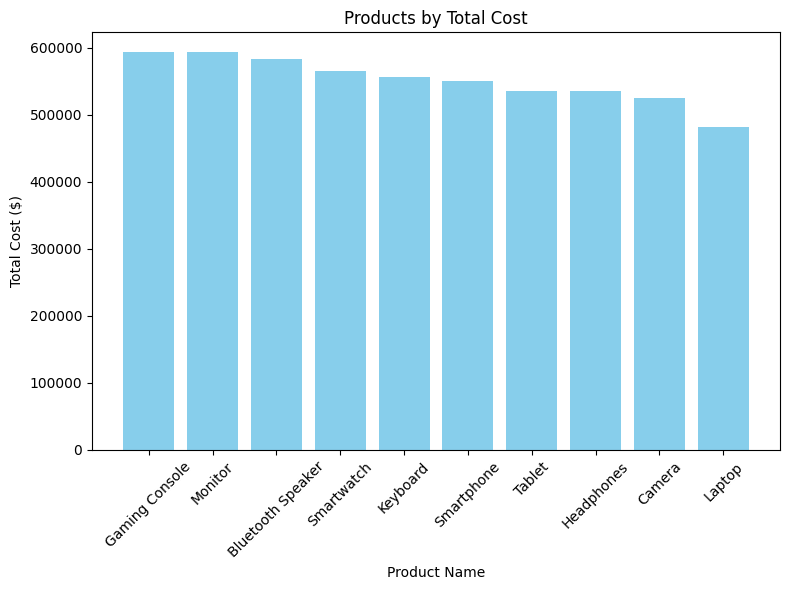

In [ ]:
# Load data from sales.csv file
sales_df = pd.read_csv('sales.csv')

product_sales = sales_df.sort_values(by='Total Cost', ascending=False)

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(product_sales['Name'], product_sales['Total Cost'], color='skyblue')
plt.xlabel('Product Name')
plt.ylabel('Total Cost ($)')
plt.title('Products by Total Cost')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


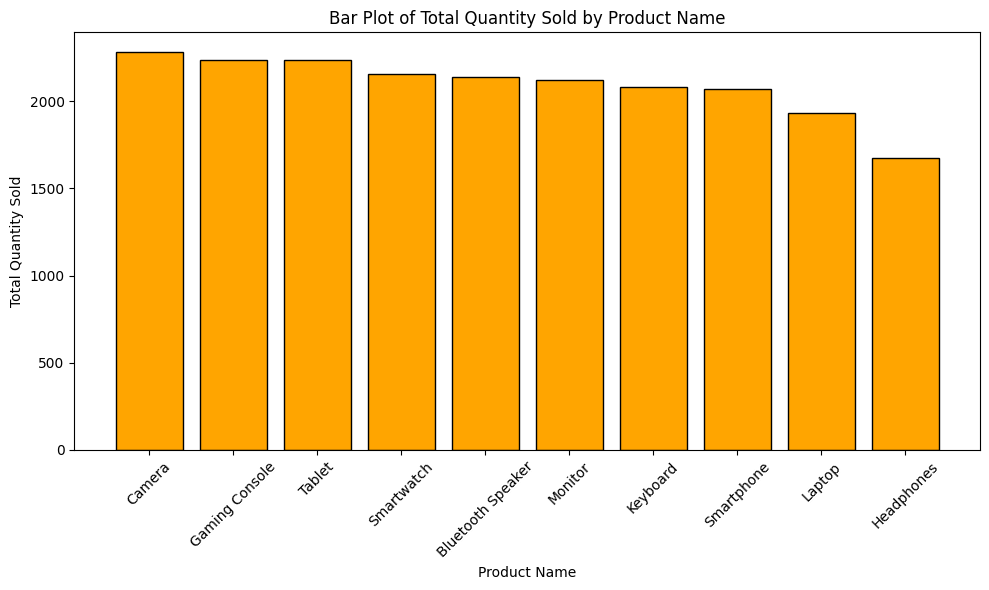

In [ ]:
# Group by 'Name' and calculate the total quantity for each product
quantity_by_product = sales_df.groupby('Name')['Quantity'].sum().reset_index()

quantity_by_product_asc = quantity_by_product.sort_values(by='Quantity', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(quantity_by_product_asc['Name'], quantity_by_product_asc['Quantity'], color='orange', edgecolor='black')
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Sold')
plt.title('Bar Plot of Total Quantity Sold by Product Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()